# Physics-Informed Neural Network (PINN) for Beam Deflection

# Importing packages

In [25]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## The Euler-Bernoulli Beam Equation

In [26]:
E = 210e9  # Young's Modulus for steel (Pa)
I = 3.255e-6 # Moment of inertia for a sample beam (m^4)
L = 5.0    # Length of the beam (m)
q0 = 1000 # Uniform distributed load (N/m)


# Analytical solution for comparison
def analytical_solution(x, q, E, I, L):
    return (q * x / (24 * E * I)) * (L**3 - 2 * L * x**2 + x**3)

## The Neural Network Class

In [27]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.net(x)

model = PINN().to(device)

# Initial Weights
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

model.apply(init_weights)

PINN(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Tanh()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Tanh()
    (6): Linear(in_features=50, out_features=1, bias=True)
  )
)

## Boundary Conditions and Loss Function

In [28]:
n_collocation = 2000
x_collocation = torch.linspace(0, L, n_collocation, requires_grad=True).view(-1, 1).to(device)

# Boundary points
x_bc = torch.tensor([[0.0], [L]], dtype=torch.float32, requires_grad=True).to(device)
y_bc = torch.tensor([[0.0], [0.0]], dtype=torch.float32).to(device)

def compute_loss():
    y = model(x_collocation)
    dy = torch.autograd.grad(y, x_collocation, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    d2y = torch.autograd.grad(dy, x_collocation, grad_outputs=torch.ones_like(dy), create_graph=True)[0]
    d3y = torch.autograd.grad(d2y, x_collocation, grad_outputs=torch.ones_like(d2y), create_graph=True)[0]
    d4y = torch.autograd.grad(d3y, x_collocation, grad_outputs=torch.ones_like(d3y), create_graph=True)[0]

    f = q0 / (E * I)
    loss_pde = torch.mean((d4y - f)**2)

    # Boundary loss - deflection conditions
    y_bc_pred = model(x_bc)
    loss_bc = torch.mean((y_bc_pred - y_bc)**2)
    
    # Moment boundary conditions
    y_bc_temp = model(x_bc)
    dy_bc = torch.autograd.grad(y_bc_temp, x_bc, grad_outputs=torch.ones_like(y_bc_temp), create_graph=True)[0]
    d2y_bc = torch.autograd.grad(dy_bc, x_bc, grad_outputs=torch.ones_like(dy_bc), create_graph=True)[0]
    loss_moment = torch.mean(d2y_bc**2)

    return loss_pde + loss_bc + loss_moment

# Model Training

In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 15000

for epoch in range(n_epochs):
    optimizer.zero_grad()
    
    loss = compute_loss()

    loss.backward()

    optimizer.step()
    
    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.6f}')

print("Training complete.")

Epoch [1000/15000], Loss: 0.000001
Epoch [2000/15000], Loss: 0.000001
Epoch [3000/15000], Loss: 0.000001
Epoch [4000/15000], Loss: 0.000001
Epoch [5000/15000], Loss: 0.000001
Epoch [6000/15000], Loss: 0.000001
Epoch [7000/15000], Loss: 0.000001
Epoch [8000/15000], Loss: 0.000001
Epoch [9000/15000], Loss: 0.000001
Epoch [10000/15000], Loss: 0.000000
Epoch [11000/15000], Loss: 0.000000
Epoch [12000/15000], Loss: 0.000000
Epoch [13000/15000], Loss: 0.000000
Epoch [14000/15000], Loss: 0.000000
Epoch [15000/15000], Loss: 0.000000
Training complete.


## Results Visualization

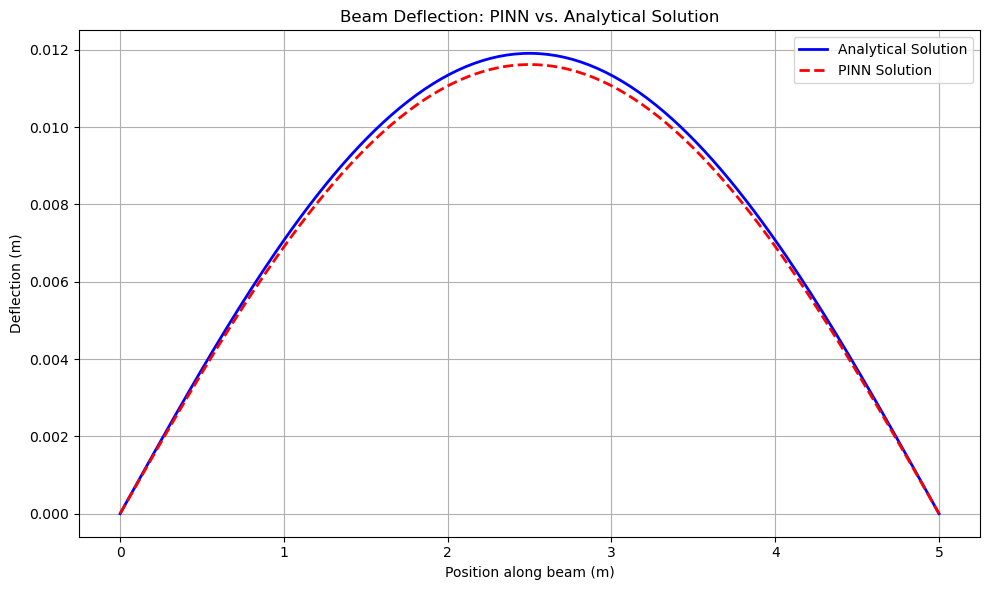

Mean Squared Error: 4.05e-08
Maximum Absolute Error: 2.89e-04 m

Boundary Condition Verification:
Deflection at x=0: 6.12e-07 m
Deflection at x=L: -4.42e-07 m
Moment at x=0: -5.23e+00 N⋅m
Moment at x=L: 2.16e+01 N⋅m


In [31]:
x_test = torch.linspace(0, L, 200).view(-1, 1).to(device)
with torch.no_grad():
    y_pred = model(x_test).detach().cpu().numpy()
x_test_np = x_test.cpu().numpy()

y_true = analytical_solution(x_test_np, q0, E, I, L)

plt.figure(figsize=(10, 6))
plt.plot(x_test_np, y_true, label='Analytical Solution', color='blue', linewidth=2)
plt.plot(x_test_np, y_pred, label='PINN Solution', color='red', linestyle='--', linewidth=2)
plt.xlabel('Position along beam (m)')
plt.ylabel('Deflection (m)')
plt.title('Beam Deflection: PINN vs. Analytical Solution')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('beam_deflection_comparison.png')
plt.show()

# Calculate and display error metrics
mse = np.mean((y_pred.flatten() - y_true.flatten())**2)
max_error = np.max(np.abs(y_pred.flatten() - y_true.flatten()))
print(f"Mean Squared Error: {mse:.2e}")
print(f"Maximum Absolute Error: {max_error:.2e} m")

# Check boundary conditions
print("\nBoundary Condition Verification:")
x_check = torch.tensor([[0.0], [L]], requires_grad=True).to(device)
y_check = model(x_check)
dy_check = torch.autograd.grad(y_check, x_check, grad_outputs=torch.ones_like(y_check), create_graph=True)[0]
d2y_check = torch.autograd.grad(dy_check, x_check, grad_outputs=torch.ones_like(dy_check), create_graph=True)[0]

print(f"Deflection at x=0: {y_check[0].item():.2e} m")
print(f"Deflection at x=L: {y_check[1].item():.2e} m")
print(f"Moment at x=0: {-E*I*d2y_check[0].item():.2e} N⋅m")
print(f"Moment at x=L: {-E*I*d2y_check[1].item():.2e} N⋅m")